### Summary
- **Algorithms and Feature Sets**: 
    - We tested two algorithms (**Random Forest and XGBoost**) using different combinations of static and text features. There were three feature types: **TF-IDF**, **embeddings**, and a combination of TF-IDF + embeddings.

- **Feature Types**:

    - **TF-IDF**: For TF-IDF features, we only considered the title. This choice was made because adding the body would introduce more noise. Additionally, analysis from previous tasks showed that a good title is a key factor for successful posts, regardless of the body content.
    - **Embeddings**: For embeddings, we combined the title and body to provide more context.Using Sentence-BERT, specifically the **paraphrase-MiniLM-L6-v2** model, provides contextualized, sentence-level embeddings that capture the nuances and meanings of entire sentences, unlike Word2Vec which generates context-independent word embeddings. This leads to improved performance in tasks requiring semantic understanding, as Sentence-BERT effectively handles complex and ambiguous sentences.
    - **TF-IDF + Embeddings**: This combined approach leveraged both the frequency-based insights of TF-IDF and the contextual understanding of embeddings.
    
- **Outlier Removal**: 
    - In the training set, we excluded outliers by setting a threshold of **0.99**. Removing outliers helps to avoid significant bias in predictions. While this approach involves a trade-off, it is necessary to mitigate the influence of extreme values, which can skew the model's performance.

- **Performance**: 
    - Random Forest with embedding features performed notably well(**R2 = 0.84**). This is logical given the small data size (**4000~**), where simpler models like Random Forest are less prone to overfitting compared to more complex models like XGBoost.
    - Embedding features provided better performance as they capture the context between words, unlike TF-IDF, which relies solely on single word frequency.
 
- **Interpretation**
    - From the feature importance of the best model (Random Forest with embeddings), it is evident that the text-related features, specifically two embeddings, dominate the contribution to the prediction. Unfortunately, it is challenging to interpret the details of these two embeddings as they exist in the embedding space.

In [13]:
import pandas as pd
import spacy
import numpy as np
import re
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

In [ ]:
# Load English tokenizer, lemmatizer, and stop words from spaCy
spacy_en = spacy.load('en_core_web_sm')

### Helper Function

In [ ]:
def tokenizer(text):
    return [tok.lemma_.lower() for tok in spacy_en(text) if not tok.is_stop and not tok.is_punct and not tok.is_space and not tok.is_digit]

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = tokenizer(text)
    return ' '.join(tokens)

def remove_outliers(data, threshold=0.99):
    upper_threshold = data['score'].quantile(threshold)
    return data[data['score'] <= upper_threshold]

def extract_features(data, feature_set='tfidf_embedding'):
    if 'tfidf_features' not in data.columns:
        # TF-IDF on preprocessed 'title'
        tfidf = TfidfVectorizer(max_features=1000)
        data['tfidf_features'] = list(tfidf.fit_transform(data['title_processed']).toarray())
        
    if 'text_embeddings' not in data.columns:
        # Sentence-BERT embeddings on 'title' + 'body'
        sentence_bert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        data['text_embeddings'] = list(sentence_bert_model.encode((data['title'] + ' ' + data['body'].fillna('')).tolist(), show_progress_bar=True))
    
    tfidf_features_dense = np.array(data['tfidf_features'].tolist())
    text_embeddings = np.array(data['text_embeddings'].tolist())
    additional_features = data[['tag_encoded', 'upvote_ratio', 'year_month_encoded']].values
    
    if feature_set == 'tfidf':
        combined_features = np.hstack([tfidf_features_dense, additional_features])
    elif feature_set == 'embedding':
        combined_features = np.hstack([text_embeddings, additional_features])
    elif feature_set == 'tfidf_embedding':
        combined_features = np.hstack([tfidf_features_dense, text_embeddings, additional_features])
    else:
        raise ValueError(f"Unsupported feature set: {feature_set}")
    
    return combined_features

def train_and_evaluate(X_train, X_valid, y_train, y_valid, model_type='rf', feature_set=''):
    if model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'xgb':
        model = XGBRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    
    # Save the model
    joblib.dump(model, f'{model_type}_{feature_set}_model.pkl')
    
    return mse, r2

def plot_feature_importances(importances, model_name, feature_names):
    indices = np.argsort(importances)[-20:]  # Top 20 features
    plt.figure(figsize=(10, 8))
    plt.title(f"Top 20 Feature Importances for {model_name}")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

### Training and Prediction

In [3]:
# Load data
data = pd.read_csv('askscience_data.csv')
data = data.sort_values(by='score', ascending=False).drop_duplicates(subset=['url'], keep='first')

# Remove outliers
data = remove_outliers(data)

# Preprocess 'title' for TF-IDF
data['title_processed'] = data['title'].fillna('').apply(preprocess_text)

# Encode the 'tag' feature
label_encoder = LabelEncoder()
data['tag_encoded'] = label_encoder.fit_transform(data['tag'])

# Extract and encode datetime features
data['datetime'] = pd.to_datetime(data['datetime'])
data['year_month'] = data['datetime'].dt.to_period('M').astype(str)
data['year_month_encoded'] = LabelEncoder().fit_transform(data['year_month'])

# Standardize the numerical features
scaler = StandardScaler()
data[['upvote_ratio']] = scaler.fit_transform(data[['upvote_ratio']])

# Prepare target variable
target = data['score'].values

results = []

for feature_set in ['tfidf', 'embedding', 'tfidf_embedding']:
    combined_features = extract_features(data, feature_set)
    X_train, X_valid, y_train, y_valid = train_test_split(combined_features, target, test_size=0.2, random_state=42)
    
    for model_type in ['rf', 'xgb']:
        mse, r2 = train_and_evaluate(X_train, X_valid, y_train, y_valid, model_type, feature_set)
        results.append({
            'Feature_Set': feature_set,
            'Model': model_type,
            'MSE': mse,
            'R2': r2
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df


/Users/d.liu/anaconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/115 [00:00<?, ?it/s]

       Feature_Set Model           MSE        R2
0            tfidf    rf  3.763790e+06  0.816384
1            tfidf   xgb  3.731119e+06  0.817978
2        embedding    rf  3.342848e+06  0.836920
3        embedding   xgb  3.571570e+06  0.825761
4  tfidf_embedding    rf  3.411456e+06  0.833573
5  tfidf_embedding   xgb  3.544070e+06  0.827103


In [6]:
results_df.sort_values(by='R2', ascending=False)

,Feature_Set,Model,MSE,R2
2,embedding,rf,3.342848e+06,0.836920
4,tfidf_embedding,rf,3.411456e+06,0.833573
5,tfidf_embedding,xgb,3.544070e+06,0.827103
3,embedding,xgb,3.571570e+06,0.825761
1,tfidf,xgb,3.731119e+06,0.817978
0,tfidf,rf,3.763790e+06,0.816384


### Interpretation

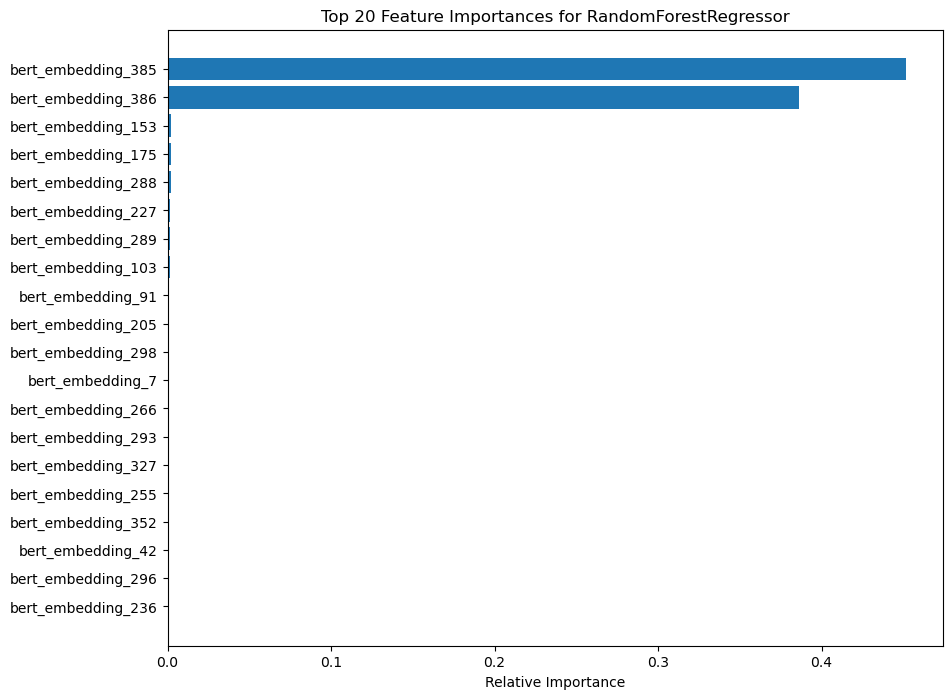

In [14]:
# Get feature importances from the loaded model
rf_embedding = joblib.load('rf_embedding_model.pkl')
rf_feature_importances = rf_embedding.feature_importances_



# Get feature names
text_feature_names = [f'bert_embedding_{i}' for i in range(len(data['text_embeddings']))]
additional_feature_names = ['tag_encoded', 'upvote_ratio', 'year_month_encoded']
all_feature_names = text_feature_names + additional_feature_names

# Plot feature importances for the Random Forest model
plot_feature_importances(rf_feature_importances, "RandomForestRegressor", all_feature_names)

In [11]:
len(data['text_embeddings'])

3669